# Test over Synthetic Data - part 1

We will generate 1000 data points. Each data point will contain 70 predictors ($X_i = x_{i1}, x_{i2}, \dots, x_{i70}$) and the response of the system ($y_i$). To generate the random data points $\mathbf{X}=<X_1, X_2, \dots, X_{1000}>$, we sample a thousand times from the binomial distribution with $n=70$ and $p=0.5$.

Let's first import the necessary modules.

In [1]:
import importlib
import sys
main_spec = importlib.util.find_spec("main")
found = main_spec is not None
project_root = ""
if not found:
    !rm -rf noisy-generalized-boolean
    !git clone https://github.com/RohanBh/noisy-generalized-boolean
    project_root = "noisy-generalized-boolean/"
    sys.path.append(f"{project_root}")

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import main
from IPython.display import FileLink

#### NOTE
Set the variable `load_samples` to `False` if you want to run a new MCMC (which may take a few minutes). Otherwise, the data (samples) is loaded from the previous MCMC that was run.

In [3]:
load_samples = False

To generate $\mathbf{X}$, we will use a simple `numpy` trick.

In [4]:
X = np.random.rand(1000, 70)
X = np.round(X)
X

array([[1., 1., 0., ..., 0., 1., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 1., 1., 1.],
       [1., 1., 0., ..., 0., 0., 0.]])

In [5]:
X.shape

(1000, 70)

Now that we have $\mathbf{X}$, it's time to generate our synthetic system's response $\mathbf{Y}$. To do that, first we'll need to identify the noisy function of actual predictors according to which response is made. Since our statistical method works for sparse models, we say that this underlying function depends only on the following 4 predictors out of 70 predictors:
                $$M = <x_{13}, x_{31}, x_{38}, x_{55}>$$

We'll represent this function by $F: \{0,1\}^4 \rightarrow \mathbb{Z}_{3} $, where $\mathbb{Z}_{3} = \{0, 1, 2\}$.

We have a generated boolean function stored as a csv. Lets load it.

In [6]:
df = pd.read_csv(f"{project_root}data/bool_func.csv", index_col=0)
df

,x55,x38,x31,x13,y0,y1,y2
0,0.0,0.0,0.0,0.0,7.715613e-01,4.817829e-10,2.284387e-01
1,0.0,0.0,0.0,1.0,2.581223e-04,9.997419e-01,1.238610e-21
2,0.0,0.0,1.0,0.0,9.999999e-01,7.076523e-08,2.697647e-08
3,0.0,0.0,1.0,1.0,9.032021e-01,1.337596e-14,9.679786e-02
4,0.0,1.0,0.0,0.0,9.925948e-01,4.670690e-03,2.734479e-03
5,0.0,1.0,0.0,1.0,8.782210e-01,6.807604e-42,1.217790e-01
6,0.0,1.0,1.0,0.0,1.298939e-11,1.000000e+00,7.649856e-39
7,0.0,1.0,1.0,1.0,9.986412e-01,5.024311e-07,1.358252e-03
8,1.0,0.0,0.0,0.0,3.150446e-04,9.996850e-01,1.792178e-25
9,1.0,0.0,0.0,1.0,2.755406e-26,1.000000e+00,1.799499e-17


Each row of this boolean function is sampled from a dirichlet distribution.

Next, we define a utility function that generates the response for a row in $\mathbf{X}$.

In [7]:
def bool_func(xi):
    """Takes an index/row of truth table and returns the response 
    according to the boolean function"""
    if isinstance(xi, int):
        weight_arr = df.iloc[xi, 4:].values
    else:
        bool_arr = np.all(df.iloc[:, :4].values == xi, axis=1)
        weight_arr = df.iloc[bool_arr, 4:].iloc[0].values
    return np.random.choice(3, p=weight_arr)

With `bool_func` we can start generating responses of our synthetic system. The response depends only on **actual predictors** of the system.

In [8]:
X_actual = X[:, [55, 38, 31, 13]]
X_actual.shape

(1000, 4)

Now, we generate the response of the synthetic system $\mathbf{Y}$, for all $1000$ rows in $\mathbf{X}$.

In [9]:
Y = np.apply_along_axis(bool_func, axis=1, arr=X_actual)
Y.shape

(1000,)

Now we have all we need. Let's see if our statistical method can predict which predictors does the response depends upon.

We call the `metropolis` function from the module `main`. This function uses a **Metropolis-Hastings** MCMC algorithm. This algorithm runs a markov chain over the model space $\mathcal{M}$ and generates samples of possible models with the posterior probability $P(M \mid \mathbf{Y}, \mathbf{X})$. This behavior is true only after the markov chain has reached a steady state.

The `metropolis` function returns the generated samples.

In [10]:
samples = []
if not load_samples:
    samples = main.metropolis(X, Y, q=3, iterations=8000, show_progress=True)
    pd.DataFrame(samples).to_csv(f"{project_root}data/mcmc-1.csv")
else:
    samples = pd.read_csv(f"{project_root}data/mcmc-1.csv", index_col=0).values

********** Running MCMC **********
500: 500 iterations took 42.59 seconds                                         
1000: 500 iterations took 51.15 seconds                                         
1500: 500 iterations took 25.43 seconds                                         
2000: 500 iterations took 25.37 seconds                                         
2500: 500 iterations took 25.12 seconds                                         
3000: 500 iterations took 23.04 seconds                                         
3500: 500 iterations took 15.94 seconds                                         
4000: 500 iterations took 15.97 seconds                                         
4500: 500 iterations took 15.50 seconds                                         
5000: 500 iterations took 15.15 seconds                                         
5500: 500 iterations took 15.06 seconds                                         
6000: 500 iterations took 15.09 seconds                                    

In [11]:
FileLink(f'{project_root}data/mcmc-1.csv')

/home/rohan/Projects/PythonProjects/generalized-noisy-boolean/data/mcmc-1.csv

Click on the link above to download the generated samples.

In [12]:
plt.ioff() # turn off interactive mode for matplotlib

In [13]:
data = np.array(samples)
data.shape

(8001, 70)

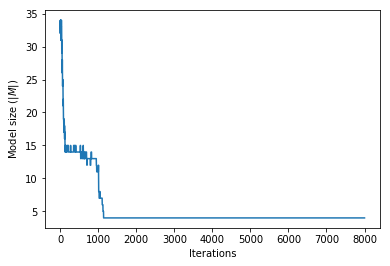

In [14]:
plt.plot(np.arange(data.shape[0]), np.count_nonzero(data, axis=1))
plt.xlabel("Iterations")
plt.ylabel(r"Model size ($\vert M \vert$)")
plt.show()

We see that the markov chain enters steady state after around 2500 iterations. We discard the samples before that.

In [15]:
data = data[2500:]
data.shape

(5501, 70)

The next plot gives the posterior probability that predictor $i$ is a part of the model given $Y$ and $X$.

$$
     \begin{align*}
     P(j \in M \mid Y, X) &= \sum_{M \in \mathcal{M}} P(j \in M \mid \mathbf{Y}, \mathbf{X}, M) P(M \mid \mathbf{Y}, \mathbf{X}) \\
         &= \hat{\mathbb{E}}[I_M(j)]_{P(M|\mathbf{Y},\mathbf{X})} \\
         &= \frac{1}{T} \sum_{t=1}^T I_{M^{(t)}} (j)
     \end{align*}
$$

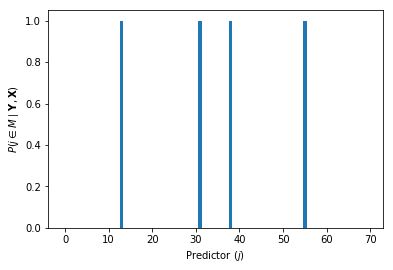

In [16]:
plt.bar(np.arange(data.shape[1]), data.mean(axis=0))
plt.xlabel("Predictor ($j$)")
plt.ylabel(r"$P(j \in M \mid \mathbf{Y}, \mathbf{X})$")
plt.show()

We can see that the **actual predictors** have very high posterior probability.

In [17]:
predicted_model = data.mean(axis=0) > 0.7
predicted_model.nonzero()

(array([13, 31, 38, 55]),)

Uncomment the following line to see number of times different models were sampled.

In [18]:
# pd.DataFrame(data).assign(count=-1).groupby(list(range(70))).count()